In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import cvxpy as cvx  #convex optimization solvers

#based on: http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/

In [2]:
%matplotlib notebook

# Primer on L$_1$ and L$_2$ norm

In [3]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

In [22]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 4050.612283
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 4992.504847
         Iterations: 63
         Function evaluations: 118


In [23]:
plt.plot(x,y,'ro')
plt.plot(x,xopt1[0] * x + xopt1[1],'k--',label='L$_1$ fit')
plt.plot(x,xopt2[0] * x + xopt2[1],'b--',label='L$_2$ fit')
plt.legend()

<IPython.core.display.Javascript object>

Optimization terminated successfully.
         Current function value: 7.448418
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 21.711619
         Iterations: 73
         Function evaluations: 141


<IPython.core.display.Javascript object>


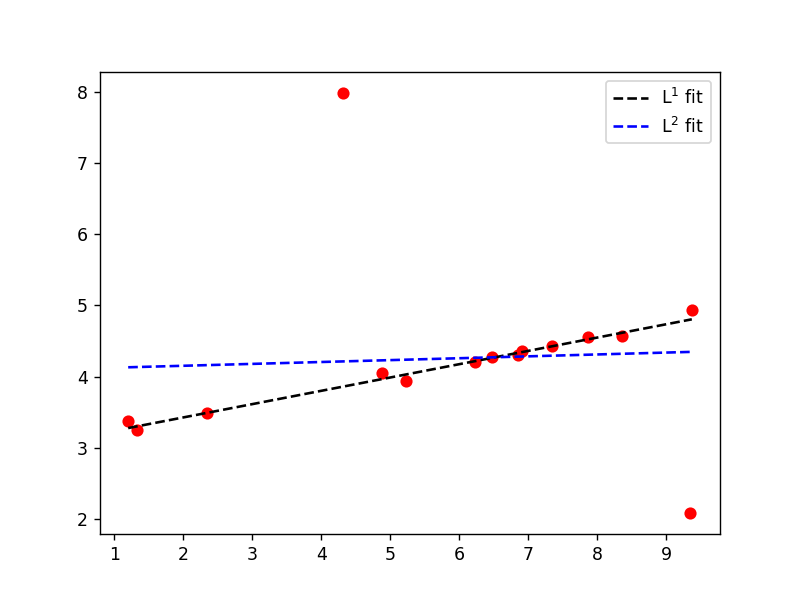

In [6]:
#add some outliers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

plt.plot(x,y2,'ro')
plt.plot(x,xopt12[0] * x + xopt12[1],'k--',label='L$^1$ fit')
plt.plot(x,xopt22[0] * x + xopt22[1],'b--',label='L$^2$ fit')
plt.legend()

# Compressed sensing

In [7]:
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)


<IPython.core.display.Javascript object>


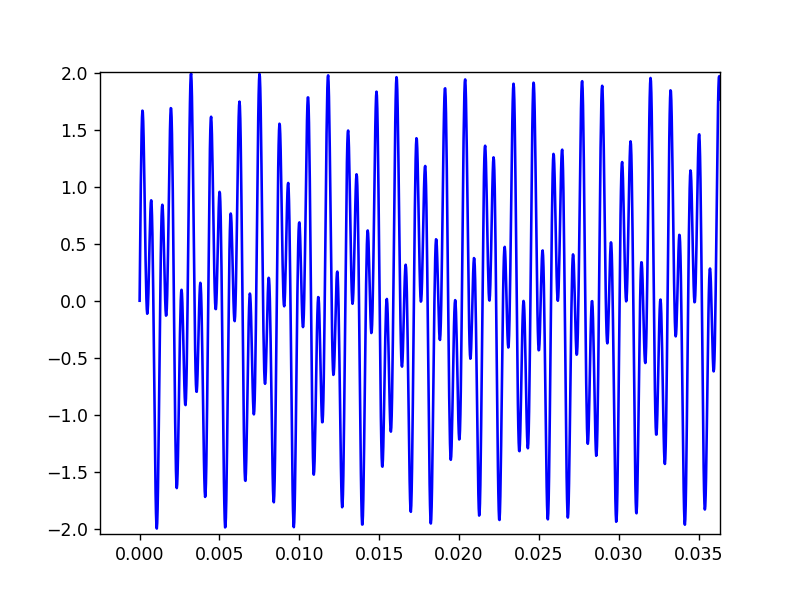

In [8]:
plt.plot(t,y,'b-')

<IPython.core.display.Javascript object>


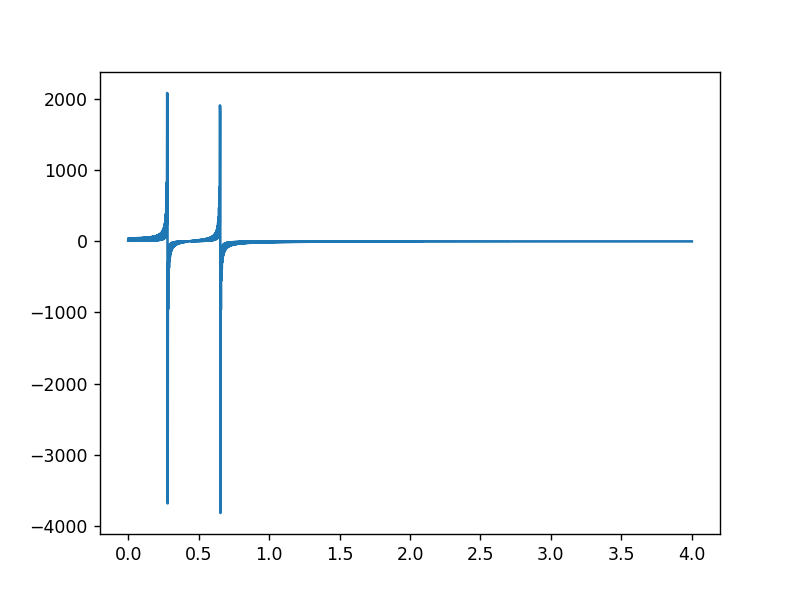

In [10]:
yf = spfft.dct(y) #discrete cosine transform
xf = np.linspace(0.0, 1.0/(2.0*1/8.), n//2)
plt.plot(xf,yf[0:n//2])

In [11]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

<IPython.core.display.Javascript object>


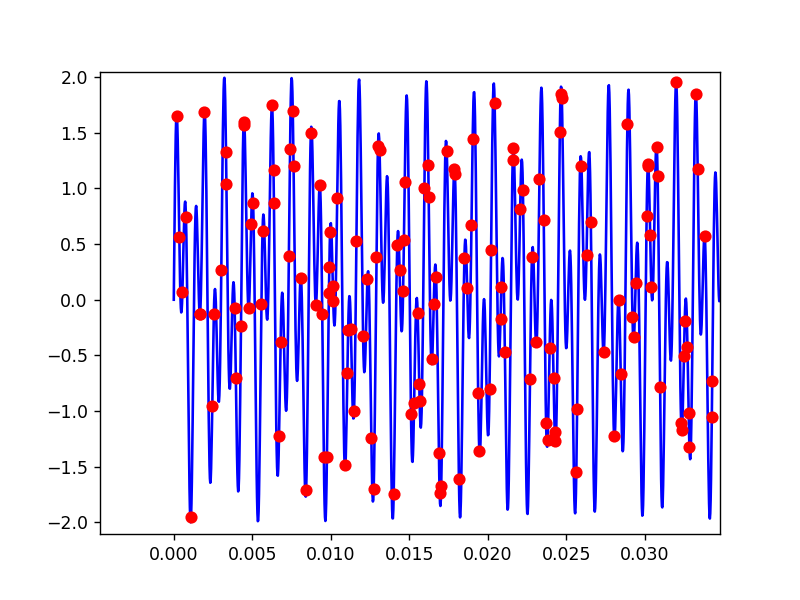

In [12]:
#original+sample
plt.plot(t,y,'b-')
plt.plot(t2,y2,'ro')

<IPython.core.display.Javascript object>


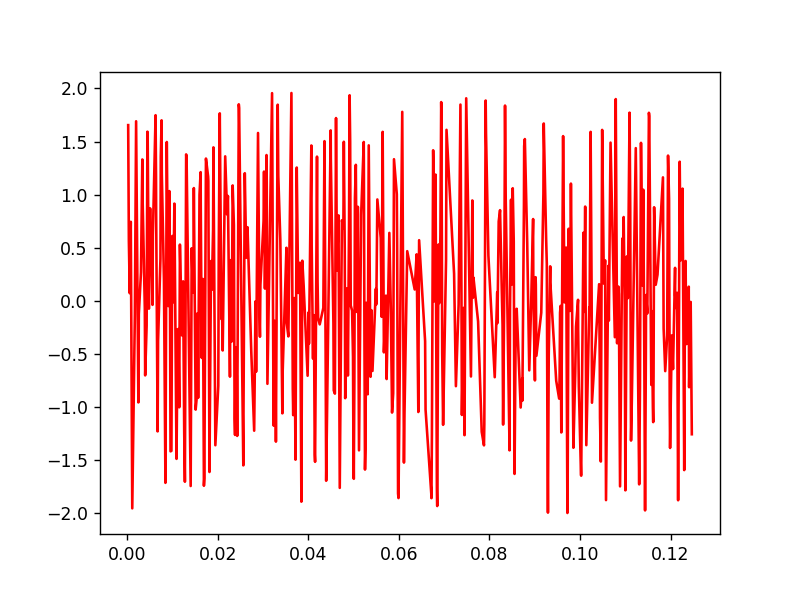

In [13]:
#our sampled signal
plt.plot(t2,y2,'r-')

In [14]:
#let's do DCT again
y2f = spfft.dct(y2) #fourier transform
x2f = np.linspace(0.0, 1.0/(2.0*1/8.), y2f.shape[0])

In [15]:
#DCT no longer looks like our original sample
plt.plot(x2f,y2f,'b')

<IPython.core.display.Javascript object>

In [16]:
#let's use compressed sensing to recreate our original signal

#we need to find A so that Ax=b
#our sample is in temporal domain, while we know that x is sparse in frequency domain 
#so make A so that it transforms to frequency domain+samples

#two steps:
#b= Bf  #B is sampling matrix and f is target signal
#Fx=f  #F is transformation matrix from temporal to frequencies

#so A=FB  (transforms+samples)

# create inverse dct matrix operator
A = spfft.idct(np.identity(n), axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1)) #L1 norm
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 10000, constraints m = 10500
          nnz(P) + nnz(A) = 2519707
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -4.0000e+04   8.00e+00   1.83e+04   1.00e-01   1.46e+00s
 200   1.8778e+00   1.50e-02   3.38e-03   1.00e-01   2.88e+00s
 400   1.7646e+00   7.59e-03   8.30e-

In [17]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x)

In [18]:
plt.plot(t,sig)

<IPython.core.display.Javascript object>

In [20]:
#what about DCT?
#this is our xv

plt.plot(xf,x[0:n//2])

<IPython.core.display.Javascript object>